In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle
import shap

/home/cibin/virtualenvs/cbd_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_df = pd.read_csv("data/P4_engineered_data.csv")
data_df.head()

,timestamp,Phone_pressure,Phone_ACC_X,Phone_ACC_Y,Phone_ACC_Z,Phone_GRAVITY_X,Phone_GRAVITY_Y,Phone_GRAVITY_Z,Phone_GYRO_X,Phone_GYRO_Y,...,Phone_AUDIO_W,Phone_AUDIO_X,Phone_AUDIO_Y,Phone_AUDIO_Z,Phone_ROTATION_VECTOR_A,Phone_ROTATION_VECTOR_B,Phone_ROTATION_VECTOR_C,Phone_ROTATION_VECTOR_D,Phone_ROTATION_VECTOR_E,activity
0,2017-06-29 09:57:00,963.3365,-0.512534,-9.417217,1.2502,2.269286,-9.402923,-1.61424,-0.000872,0.0035,...,8513.0,7546.2360,32767.0,45.0,-0.711522,0.431162,-0.417772,0.365106,0.523599,Eat
1,2017-06-29 09:57:03,963.3365,-0.512534,-9.417217,1.2502,2.269286,-9.402923,-1.61424,-0.000872,0.0035,...,13602.0,7547.2380,32767.0,45.0,-0.711522,0.431162,-0.417772,0.365106,0.523599,Eat
2,2017-06-29 09:57:08,963.3365,-0.512534,-9.417217,1.2502,2.269286,-9.402923,-1.61424,-0.000872,0.0035,...,5198.0,7548.5195,32767.0,45.0,-0.711522,0.431162,-0.417772,0.365106,0.523599,Eat
3,2017-06-29 09:57:09,963.3365,-0.512534,-9.417217,1.2502,2.269286,-9.402923,-1.61424,-0.000872,0.0035,...,4686.0,7548.1580,32767.0,45.0,-0.711522,0.431162,-0.417772,0.365106,0.523599,Eat
4,2017-06-29 09:57:10,963.2255,-0.512534,-9.417217,1.2502,2.269286,-9.402923,-1.61424,-0.000872,0.0035,...,5239.0,7547.8667,32767.0,45.0,-0.711522,0.431162,-0.417772,0.365106,0.523599,Eat


In [4]:
data_df.columns

Index(['timestamp', 'Phone_pressure', 'Phone_ACC_X', 'Phone_ACC_Y',
       'Phone_ACC_Z', 'Phone_GRAVITY_X', 'Phone_GRAVITY_Y', 'Phone_GRAVITY_Z',
       'Phone_GYRO_X', 'Phone_GYRO_Y', 'Phone_GYRO_Z', 'Phone_LA_X',
       'Phone_LA_Y', 'Phone_LA_Z', 'Phone_MAG_X', 'Phone_MAG_Y', 'Phone_MAG_Z',
       'Phone_ORI_X', 'Phone_ORI_Y', 'Phone_ORI_Z', 'Phone_AUDIO_W',
       'Phone_AUDIO_X', 'Phone_AUDIO_Y', 'Phone_AUDIO_Z',
       'Phone_ROTATION_VECTOR_A', 'Phone_ROTATION_VECTOR_B',
       'Phone_ROTATION_VECTOR_C', 'Phone_ROTATION_VECTOR_D',
       'Phone_ROTATION_VECTOR_E', 'activity'],
      dtype='object')

In [5]:
data_df.drop(columns=['timestamp'], inplace=True)

In [11]:
label_dict = {activity: i for i, activity in enumerate(data_df.activity.value_counts().index.tolist())}
label_dict

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25}

In [12]:
data_df.activity = data_df.activity.map(lambda x: label_dict[x])

In [13]:
def run_train_test_split(df, label_name, test_ratio=0.3):
    X = df.drop([label_name], axis=1)
    y = df[label_name]

    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=test_ratio, random_state=42)

    # Print the shapes of the training and testing sets
    print('Training set shape:', X_train_df.shape, y_train_df.shape)
    print('Testing set shape:', X_test_df.shape, y_test_df.shape)

    return X_train_df, X_test_df, y_train_df, y_test_df

# Train test split

In [14]:
X_train_df, X_test_df, y_train_df, y_test_df = run_train_test_split(data_df, label_name='activity', test_ratio=0.2)

Training set shape: (230696, 28) (230696,)
Testing set shape: (57675, 28) (57675,)


In [9]:
def train_test(classifier, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=48)
    classifier.fit(X_train, y_train)
    
    train_accuracy = classifier.score(X_train, y_train)
    test_accuracy = classifier.score(X_test, y_test)
    
    print("Train accuracy: {}, Test accuracy: {}".format(train_accuracy, test_accuracy))
    
    performance_metrics = {
        'train_accuracy':train_accuracy,
        'test_accuracy':test_accuracy
    }
    return performance_metrics, classifier

In [10]:
X = data_df.drop(columns=['activity'])
y = data_df['activity']

In [14]:
models_info_dict_list = []

In [15]:
# Trial 1- logistic regression

In [16]:
# Define the pipeline with Logistic Regression
trial1 = Pipeline([
    ("classifier", LogisticRegression())
])

performance_metrics, clf1 = train_test(trial1, X, y)
performance_metrics['model_id'] = 'trial1'
models_info_dict_list.append(performance_metrics)

/home/cibin/virtualenvs/cbd_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy: 0.32957582370837535, Test accuracy: 0.330156880695768


In [18]:
# Trial 2- logistic regression + StandardScalar

In [17]:
# Define the pipeline with Logistic Regression and StandardScaler
trial2 = Pipeline([
    ("scaler", StandardScaler()),       # Add StandardScaler for normalization
    ("classifier", LogisticRegression())
])

performance_metrics, cl2 = train_test(trial2, X, y)
performance_metrics['model_id'] = 'trial2'
models_info_dict_list.append(performance_metrics)

/home/cibin/virtualenvs/cbd_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy: 0.4856434773763397, Test accuracy: 0.48276531702107


In [ ]:
# Trial 3 logistic regression + PCA + Standard Scaler 

In [18]:
# Define the pipeline with Logistic Regression and StandardScaler
trial3 = Pipeline([
    ("scaler", StandardScaler()),       # Add StandardScaler for normalization
    ("pca", PCA(n_components=0.95)),  # Add PCA with 95% explained variance
    ("classifier", LogisticRegression())
])

performance_metrics, clf3 = train_test(trial3, X, y)
performance_metrics['model_id'] = 'trial3'
models_info_dict_list.append(performance_metrics)

/home/cibin/virtualenvs/cbd_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy: 0.44161218431833105, Test accuracy: 0.4398901419000458


In [ ]:
# Trial 4- Random Forest with default configuration

In [19]:
trial4 = Pipeline([
    ("classifier", RandomForestClassifier(random_state=0))
])

performance_metrics, clf4 = train_test(trial4, X, y)
performance_metrics['model_id'] = 'trial4'
models_info_dict_list.append(performance_metrics)

Train accuracy: 0.9051775955020853, Test accuracy: 0.9034025494846933


In [16]:
# Trial 5- PCA with 95 percent variance + Random Forest with default configuration

In [20]:
trial5 = Pipeline([
    ("pca", PCA(n_components=0.95)),  # Add PCA with 95% explained variance
    ("classifier", RandomForestClassifier(random_state=0))
])

performance_metrics, clf5 = train_test(trial5, X, y)
performance_metrics['model_id'] = 'trial5'
models_info_dict_list.append(performance_metrics)

Train accuracy: 0.9051683481445177, Test accuracy: 0.5940937400302387


In [23]:
# Trial 6- Standard Scalar + PCA with 95 percent variance + Random Forest with default configuration

In [21]:
trial6 = Pipeline([
    ("scaler", StandardScaler()),       # Add StandardScaler for normalization    
    ("pca", PCA(n_components=0.95)),  # Add PCA with 95% explained variance
    ("classifier", RandomForestClassifier(random_state=0))
])

performance_metrics, clf6 = train_test(trial6, X, y)
performance_metrics['model_id'] = 'trial6'
models_info_dict_list.append(performance_metrics)

Train accuracy: 0.9051775955020853, Test accuracy: 0.8621086651963437


In [22]:
eval_df = pd.DataFrame(models_info_dict_list)
eval_df

,train_accuracy,test_accuracy,model_id
0,0.329576,0.330157,trial1
1,0.485643,0.482765,trial2
2,0.441612,0.439890,trial3
3,0.905178,0.903403,trial4
4,0.905168,0.594094,trial5
5,0.905178,0.862109,trial6


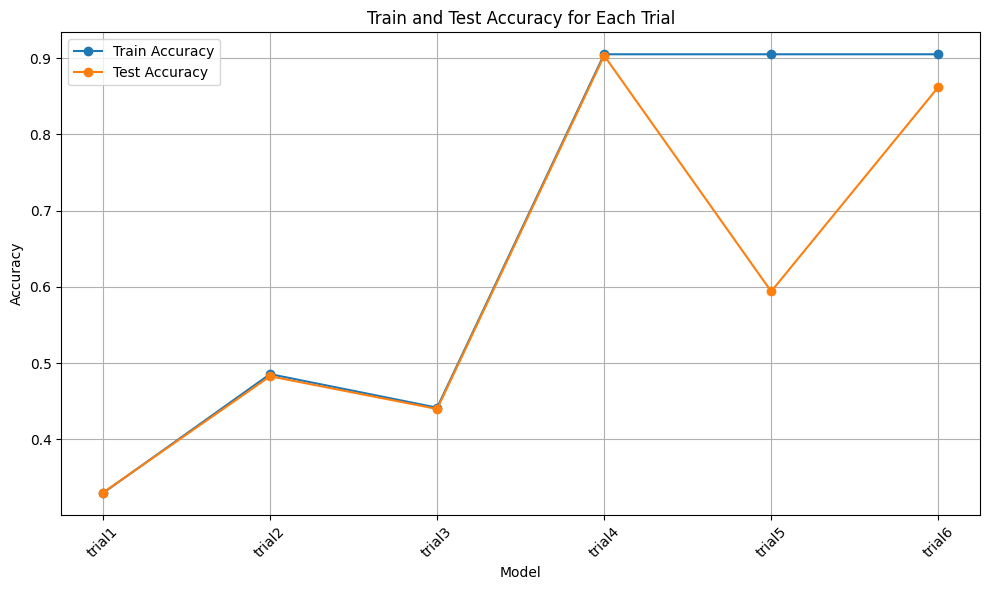

In [23]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(eval_df['model_id'], eval_df['train_accuracy'], marker='o', label='Train Accuracy')
plt.plot(eval_df['model_id'], eval_df['test_accuracy'], marker='o', label='Test Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy for Each Trial')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

Trial 4- Random Forest with default configuration has the best accuracy

In [25]:
# Saving the model locally

In [26]:
import pickle

In [29]:
# save the model to disk
filename = 'CHECKPOINTS/final_model.sav'
pickle.dump(clf4, open(filename, 'wb'))

In [20]:
clf = RandomForestClassifier(random_state=0)

In [31]:
print(label_dict)

{'At home': 0, 'In computer': 1, 'Walk': 2, 'Picnic ': 3, 'In bus': 4, 'Walking&party': 5, 'Video games/At home': 6, 'Pause': 7, 'In computer/Work': 8, 'Train': 9, 'In vehicle': 10, 'Sleep': 11, 'Eat': 12, 'Meeting': 13, 'Cooking': 14, 'In computer/At home': 15, 'Movie': 16, 'Shopping& wearing': 17, 'Work': 18, 'Video games': 19, 'Phone was out of the pocket (forgot)/At home': 20, 'Eat/At home': 21, 'Shop/Walk': 22, 'Shop': 23, 'Eat/Phone was out of the pocket (forgot)/At home': 24, 'On bus stop/Walk': 25}


In [23]:
clf.fit(X_train_df, y_train_df)

RandomForestClassifier(random_state=0)

In [30]:
y_test_pred = clf.predict(X_test_df)
y_train_pred = clf.predict(X_train_df)

In [31]:
# Evaluate the performance
test_accuracy = accuracy_score(y_test_df, y_test_pred)
train_accuracy = accuracy_score(y_train_df, y_train_pred)

print("train_accuracy:", train_accuracy)
print("test_accuracy:", test_accuracy)

train_accuracy: 0.9050655407982799
test_accuracy: 0.9038925010836585


In [33]:
y_test_df.value_counts()

0     13323
1      5419
2      4036
3      3823
4      3172
5      2911
6      2534
7      2499
8      1968
9      1944
10     1899
11     1783
12     1768
13     1649
14     1428
15     1306
16     1280
17     1261
19      793
18      789
20      603
21      400
22      337
23      300
25      230
24      220
Name: activity, dtype: int64

In [34]:
from sklearn.metrics import classification_report


In [35]:
print(classification_report(y_test_df,y_test_pred))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83     13323
           1       1.00      0.80      0.89      5419
           2       1.00      0.93      0.96      4036
           3       1.00      1.00      1.00      3823
           4       1.00      0.87      0.93      3172
           5       1.00      0.57      0.72      2911
           6       1.00      0.57      0.72      2534
           7       1.00      1.00      1.00      2499
           8       1.00      1.00      1.00      1968
           9       1.00      0.88      0.94      1944
          10       1.00      0.97      0.99      1899
          11       1.00      0.70      0.82      1783
          12       1.00      1.00      1.00      1768
          13       1.00      0.98      0.99      1649
          14       1.00      1.00      1.00      1428
          15       1.00      0.98      0.99      1306
          16       1.00      1.00      1.00      1280
          17       1.00    

In [36]:
y_test_df.shape

(57675,)

In [37]:
y_train_df.shape

(230696,)

In [9]:
X_train_df, X_test_df, y_train_df, y_test_df = run_train_test_split(data_df, label_name='activity', test_ratio=0.2)

Training set shape: (230696, 28) (230696,)
Testing set shape: (57675, 28) (57675,)


In [11]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train_df.values, y_train_df.values)

RandomForestClassifier(random_state=0)

In [13]:
# save the model to disk
filename = 'CHECKPOINTS/model_v4.sav'
pickle.dump(clf, open(filename, 'wb'))

## Model Explainability

In [15]:
filename = 'CHECKPOINTS/model_v4.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [18]:
explainer = shap.Explainer(loaded_model, X_train_df.values,
                           feature_names=X_train_df.columns
                          )


In [20]:
shap_values = explainer(X_test_df.head(10))
shap.plots.beeswarm(shap_values)

100%|===================| 259/260 [00:16<00:00]        

ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!

In [21]:
shap_values

.values =
array([[[-3.49188085e-02, -1.94653944e-02, -4.47559760e-02, ...,
         -1.22452021e-03, -2.08409089e-03, -1.93317987e-03],
        [-1.05100821e-02, -4.30986153e-03,  1.96734820e-03, ...,
         -4.91494905e-04,  4.22004874e-04, -8.62990106e-04],
        [ 1.50145206e-04, -2.89486127e-03,  5.33947131e-04, ...,
          4.71583917e-05,  3.58141239e-04, -1.77184060e-03],
        ...,
        [-1.70236156e-03, -1.91361385e-03,  2.08143345e-03, ...,
          3.26807359e-04, -1.16342001e-04, -5.27487747e-04],
        [-3.50866694e-03, -3.19121282e-03, -1.58206033e-03, ...,
         -1.96377598e-03,  2.09725833e-04, -3.13961058e-05],
        [ 8.50195280e-04,  2.57143959e-04,  5.22867863e-04, ...,
          1.20945166e-04,  2.73809499e-06, -3.33547631e-04]],

       [[-3.75739929e-03, -2.68670310e-02, -4.71850264e-02, ...,
         -1.57880870e-03, -6.39798113e-03, -3.06127351e-03],
        [-2.16774096e-02,  1.67418197e-03,  2.81181702e-03, ...,
          6.98427958e-04,  1